In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# The UNSW dataset
Published in "UNSW-NB15: A Comprehensive Data set for Network
Intrusion Detection systems" https://ieeexplore.ieee.org/document/7348942

This data set has a hybrid of the real modern normal and the contemporary synthesized attack activities of the network traffic. Existing and novel methods are utilised to generate the features of the UNSWNB15 data set.

The dataset contains 47 features per observation, which include:

- basic features (i.e., destination bits per second)
- flow features (source IP address, etc.), 
- content features (i.e., Mean of the flow packet size transmitted by the dst ), 
- time features (Source inter-packet arrival time),
- derived or generated features (i. e., No. of flows that has methods such as Get and Post in http service. )
- connection features (i.e., No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26). )


# Explore the dataset

In [2]:
# read data frame
df = pd.read_csv('UNSW_NB15_training-set.csv')

print("Shape of data frame ", df.shape[0])
print("Set of 10 records")
df.head(10)

df.describe(include = "all")

Shape of data frame  82332
Set of 10 records


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,82332.000000,82332.000000,82332,82332,82332,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332,82332.000000
unique,NaN,NaN,131,13,7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,43095,47153,39339,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37000,NaN
mean,41166.500000,1.006756,NaN,NaN,NaN,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,...,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,NaN,0.550600
std,23767.345519,4.710444,NaN,NaN,NaN,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,...,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,NaN,0.497436
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,20583.750000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,NaN,0.000000
50%,41166.500000,0.014138,NaN,NaN,NaN,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,NaN,1.000000
75%,61749.250000,0.719360,NaN,NaN,NaN,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,...,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,NaN,1.000000


# Basic preprocessing

In [3]:
# drop the id and attack category, not used 
list_drop = ['id','attack_cat']
df.drop(list_drop, axis=1,inplace = True)

We need to be careful with the range anda values of the histogram:


array([[<Axes: title={'center': 'label'}>]], dtype=object)

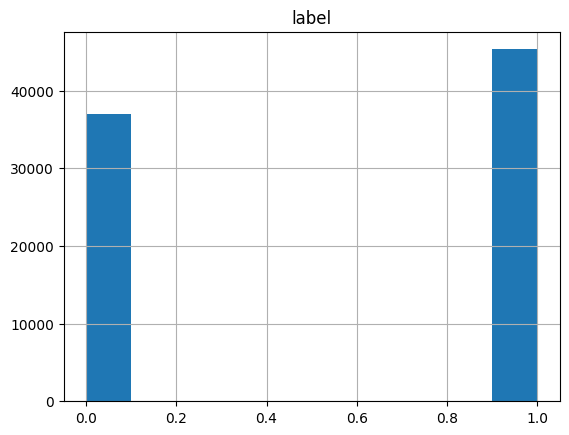

In [4]:
print("We need to be careful with the range anda values of the histogram:")
df.hist(column = "label")

In [5]:
#get set of records with label 0 and 1
# Extract rows with label equal to 0
rows_with_label_0 = df[df['label'] == 0]

print(rows_with_label_0.shape)

# Extract rows with label equal to 1
rows_with_label_1 = df[df['label'] == 1]

print(rows_with_label_1.shape)

(37000, 43)
(45332, 43)


In [6]:
def plot_histogram(hist_values, bin_edges, title = "Histogram of Number of Rows with Label 0"):
    # Plot the histogram using matplotlib
    plt.hist(hist_values, bins=bin_edges, edgecolor='black')
    plt.title(title)
    plt.xlabel("Number of Rows")
    plt.ylabel("Frequency")
    plt.show()

# Encode the categorical features
The features state, protocol  and service (number 1, 2 and 3) are encoded  using one hot vector encoding, as those are categorical variables.



## First reduce the cardinality to reduce one hot encoded features dimensionality

In [7]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X.head()
feature_names = list(X.columns)
print("Original dimensionality before one hot encoding: ")
print("X  shape ", X.shape)

print("Number of different values per column using the dataframe ")
df.describe(include='all')

Original dimensionality before one hot encoding: 
X  shape  (82332, 42)
Number of different values per column using the dataframe 


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332,82332,82332,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
unique,NaN,131,13,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,43095,47153,39339,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.006756,NaN,NaN,NaN,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,4.710444,NaN,NaN,NaN,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.014138,NaN,NaN,NaN,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,0.719360,NaN,NaN,NaN,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000


The variable state has 7 different values, service 13 and protocol 131... perhaps there are too many values for each column. Therefore we can reduce the *cardinality* of the columns to use the 6 most frequent values. Otherwise, the dimensionality of the one hot vector variables will be too high!

In [8]:
#data frame with only the categorical variables
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

#service also defines the '-' category (to represent an unknown service) 


,proto,service,state
count,82332,82332,82332
unique,131,13,7
top,tcp,-,FIN
freq,43095,47153,39339


In [9]:
DEBUG = 1
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print("Is the cardinality higher than 6? ", df_cat[feature].nunique()>6)
        print("Number of preserved records: ", sum(df[feature].isin(df[feature].value_counts().head().index)))
        print("New categories: (- takes the rest of categories)", df[feature].value_counts().head().index)
        print('----------------------------------------------------')
    
    if df_cat[feature].nunique()>6:
        #preserve only the records with values within the first 5 most frequent values (default by pandas)
        #replace with '-' if the value is not between the 5 most frequent
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

proto
nunique = 131
Is the cardinality higher than 6?  True
Number of preserved records:  77691
New categories: (- takes the rest of categories) Index(['tcp', 'udp', 'unas', 'arp', 'ospf'], dtype='object', name='proto')
----------------------------------------------------
service
nunique = 13
Is the cardinality higher than 6?  True
Number of preserved records:  80210
New categories: (- takes the rest of categories) Index(['-', 'dns', 'http', 'smtp', 'ftp'], dtype='object', name='service')
----------------------------------------------------
state
nunique = 7
Is the cardinality higher than 6?  True
Number of preserved records:  82330
New categories: (- takes the rest of categories) Index(['FIN', 'INT', 'CON', 'REQ', 'ACC'], dtype='object', name='state')
----------------------------------------------------


Let's see how the dataframe of categorical variables ended (much less unique values must appear): 

In [10]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,82332,82332,82332
unique,6,5,6
top,tcp,-,FIN
freq,43095,49275,39339


## Encode cardinality reduced columns
A total of 6 + 5 + 6 = 17 features are added, to the 42 - 3 = 39 features
We yield then 39 + 17 = 56 columns or fields

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
feature_names = list(X.columns)
print("Number of features before one hot encoding: ", len(feature_names))
#create the one hot encoder transformer and transform:
#columns 1, 2 and 3 are the ones to encode
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

print("Number of features after one hot encoding: ", X.shape)

Number of features before one hot encoding:  42
Number of features after one hot encoding:  (82332, 56)


# Prepare for model training

## Model metrics

## TP solution

### General functions

In [68]:
def split_data(x, t, test_prop, shuffle_id=None):
    if test_prop >= 1 or test_prop <= 0:
        raise ValueError('Invalid test proportion value')
    
    x_train, x_test, t_train, t_test = train_test_split(
        x,
        t,
        test_size = test_prop,
        random_state = shuffle_id)
    
    x_train = torch.Tensor(x_train).to(torch.float64)
    x_test = torch.Tensor(x_test).to(torch.float64)
    t_train = torch.Tensor(t_train.to_numpy()).to(torch.float64)
    t_test = torch.Tensor(t_test.to_numpy()).to(torch.float64)

    return x_train, x_test, t_train, t_test

def create_data_partitions(x, t, n_splits, shuffle=True, shuffle_id=None):
    if n_splits <= 1:
        raise ValueError('Invalid amount of partitions')
    
    ensambles_partitioner = KFold(n_splits=n_splits, shuffle=shuffle, random_state=shuffle_id)
    partitions_iterator = ensambles_partitioner.split(x, t)

    x_partitions = []
    t_partitions = []
    for _, (train_index, _) in enumerate(partitions_iterator):
        x_partitions.append(x[train_index])
        t_partitions.append(t[train_index])
    
    return x_partitions, t_partitions

def evaluate_model(x, w, threshold = 0.0):
    t_estimated = x @ w
    t_estimated_bin = (t_estimated >= threshold).to(torch.float64)
    
    return t_estimated_bin

def calculate_optimum_w2(x, t, alt=False):
    if alt:
        w_opt = torch.linalg.pinv(x.T @ x) @ x.T @ t
    else:
        w_opt = torch.linalg.pinv(x) @ t

    return w_opt

def calculate_optimum_w(x, t, alt=False):
    if alt:
        w_opt = torch.pinverse(x.T @ x) @ x.T @ t
    else:
        w_opt = torch.pinverse(x) @ t

    return w_opt

def calculate_error(t, t_estimated):
    N = t_estimated.shape[0]
    mse = (1 / (2 * N)) * (torch.norm(t_estimated - t, 2) ** 2)

    return mse

def calculate_f1_score(t, t_estimated):
    true_positives = torch.sum((t == 1) & (t_estimated == 1)).item()
    false_positives = torch.sum((t == 0) & (t_estimated == 1)).item()
    false_negatives = torch.sum((t == 1) & (t_estimated == 0)).item()
    
    tpfp = true_positives + false_positives
    tpfn = true_positives + false_negatives
    precision = true_positives / tpfp if tpfp > 0 else 0.0
    recall = true_positives / tpfn if tpfn > 0 else 0.0

    pr = precision + recall
    f1_score = (2 * precision * recall) / pr if pr > 0 else 0.0

    return f1_score

def calculate_accuracy(t, t_estimated):
    t_correct = torch.sum(t == t_estimated).item()
    accuracy = t_correct / len(t)

    return accuracy

def calculate_expected_calibration_error(x, t, model, n=10):
    if n <= 1:
        raise ValueError('Invalid amount of bins for ECE calculation')

    check_correlation_list = []
    x_partitions, t_partitions = create_data_partitions(x, t, n, shuffle=False)

    for x_partition, t_partition in zip(x_partitions, t_partitions):
        results = model.evaluate(x_partition, t_partition)
        accuracies = results['ensemble_results']['accuracy']
        uncerts = results['ensemble_results']['uncertainty_score']

        curr_accuracy_uncert = torch.mean(torch.stack((accuracies, uncerts), dim=1).to(torch.float64), dim=0)
        check_correlation_list.append(curr_accuracy_uncert.unsqueeze(1))

    check_correlation_tensor = torch.cat(check_correlation_list, dim=1)
    p_coef = torch.corrcoef(check_correlation_tensor)[0, 1]
    ece_estimated = (1 - torch.abs(p_coef)).item()

    return ece_estimated

### Model structure

In [28]:
class GenericModel:
    def __init__(self):
        self.x = torch.Tensor([])
        self.t = torch.Tensor([])
        self.w = torch.Tensor([])

        # used for ensembles
        self.wt = []
        self.x_partitions = []
        self.t_partitions = []
        self.num_partitions = 0
        self.train_time = 0
        self.eval_time = 0
    
    def has_ensembles(self):
        return self.num_partitions > 1

    def insert_partitions(self, x_partition, t_partition, train_on_insert = True):
        insert_completed = False
        
        if torch.is_tensor(x_partition) and torch.is_tensor(t_partition):
            if x_partition.shape[0] == t_partition.shape[0]:
                self.x_partitions.append(x_partition)
                self.t_partitions.append(t_partition)

                self.x = torch.cat((self.x, x_partition), dim=0)
                self.t = torch.cat((self.t, t_partition), dim=0)

                insert_completed = True
        elif len(x_partition) == len(t_partition):
            self.x_partitions.extend(x_partition)
            self.t_partitions.extend(t_partition)

            self.x = torch.cat((self.x, torch.cat(x_partition, dim=0)), dim=0)
            self.t = torch.cat((self.t, torch.cat(t_partition, dim=0)), dim=0)

            insert_completed = True
        
        if not insert_completed:
            raise ValueError("Partitions or elements included have different shape")

        self.num_partitions = len(self.x_partitions)
        if train_on_insert:
            self.train()
    
    def train_ensemble(self, reset=False):
        if not reset and self.num_partitions <= 0:
            return
        
        wt = []
        startIndex = 0 if reset else len(self.wt)
        for i in range(startIndex, self.num_partitions):
            wt_i = calculate_optimum_w(self.x_partitions[i], self.t_partitions[i])
            wt.append(wt_i)
        
        if reset:
            self.wt = wt
        else:
            self.wt.extend(wt)

    def train(self, reset=False):
        start = time.time()
        self.w = calculate_optimum_w(self.x, self.t)
        self.train_ensemble(reset)
        self.train_time = time.time() - start

    def run_ensemble_uq(self, x, t_real):
        # Inicializa un tensor para almacenar todas las métricas
        metrics = torch.zeros((self.num_partitions, 4))

        if self.has_ensembles:
            for i in range(self.num_partitions):
                t_i_estimated = evaluate_model(x, self.wt[i])

                # Calcula las métricas para cada modelo
                error_i_estimated = calculate_error(t_real, t_i_estimated)
                f1_score_i_estimated = calculate_f1_score(t_real, t_i_estimated)
                accuracies_i_estimated = calculate_accuracy(t_real, t_i_estimated)
                ensemble_score_i = torch.var((t_i_estimated == t_real).to(torch.float64)).item()
                
                metrics[i, 0] = accuracies_i_estimated
                metrics[i, 1] = f1_score_i_estimated
                metrics[i, 2] = error_i_estimated
                metrics[i, 3] = ensemble_score_i

        return {
            "accuracy": metrics[:, 0],
            "f1_score": metrics[:, 1],
            "error_estimated": metrics[:, 2],
            "uncertainty_score":metrics[:, 3]
        }

    def evaluate(self, x, t_real):
        start = time.time()
        t_estimated = evaluate_model(x, self.w)
        ensemble_results = self.run_ensemble_uq(x, t_real)
        self.eval_time = time.time() - start

        general_results = {
            "t_estimated": t_estimated,
            "accuracy": calculate_accuracy(t_real, t_estimated),
            "f1_score": calculate_f1_score(t_real, t_estimated),
            "error_estimated": calculate_error(t_real, t_estimated).item()
        }

        return {
            "general_results": general_results,
            "ensemble_results": ensemble_results
        }

### Create test scenario and experiments

In [80]:
def create_model_test_scenario(x, t, test_prop=0.2, shuffle=True, shuffle_id=None, use_ensembles=False, n_ensambles=10, train_on_insert=True):
    model = GenericModel()
    x_train, x_test, t_train, t_test = split_data(x, t, test_prop, shuffle_id)
    
    if use_ensembles:
        partitions = create_data_partitions(x_train, t_train, n_ensambles, shuffle=shuffle, shuffle_id=shuffle_id)
        model.insert_partitions(partitions[0], partitions[1], train_on_insert=train_on_insert)
    else:
        model.insert_partitions(x_train, t_train)

    return model, x_test, t_test

def execute_experiments(n, test_prop=0.2, use_ensembles=False, n_ensembles=10, shuffle_id=None, verbose=True, train_on_insert=True):
    if not isinstance(n_ensembles, int) and not (isinstance(n_ensembles, list) and isinstance(n_ensembles[0], int) and len(n_ensembles) == n):
        raise ValueError('Invalid n_ensembles value for experiments')

    models = []
    results_per_experiment = []
    for i in range(n):
        if verbose:
            print(f'Currently executing: {i+1}', end='\r')

        if isinstance(n_ensembles, int):
            ensembles = n_ensembles
        else:
            ensembles = n_ensembles[i]

        model, x_test, t_test = create_model_test_scenario(X, y, test_prop=test_prop, use_ensembles=use_ensembles, n_ensambles=ensembles, shuffle_id=shuffle_id, train_on_insert=train_on_insert)
        if not train_on_insert:
            model.train()

        results = model.evaluate(x_test, t_test)
        results['ece'] = calculate_expected_calibration_error(x_test, t_test, model, n=10)
        models.append(model)
        results_per_experiment.append(results)

    if verbose:
        print('Experiments completed successfully')

    return models, results_per_experiment

def print_experiment_results_list(models, results_per_experiment):
    for i, (model, results) in enumerate(zip(models, results_per_experiment)):
        print(f'\nTest #{i+1}:\n')
        print('General results:')
        print(f'Training time:      {model.train_time}')
        print(f'Evaluation time:    {model.eval_time}')
        print(f'Total Accuracy:     {results['general_results']['accuracy']}')
        print(f'Total Error:        {results['general_results']['error_estimated']}')
        print(f'Total F1 score:     {results['general_results']['f1_score']}')

        if model.has_ensembles():
            print('\nEnsemble results:')
            print(f'Accuracies:         {results['ensemble_results']['accuracy']}')
            print(f'Errors:             {results['ensemble_results']['error_estimated']}')
            print(f'F1 scores:          {results['ensemble_results']['f1_score']}')
            print(f'Uncertainty scores: {results['ensemble_results']['uncertainty_score']}')

### Graph results

In [15]:
def graph_ensemble_results(results, title='Scores per Ensemble'):
    bar_width = 0.25
    errors = results[0]
    accuracies = results[1]
    f1_scores = results[2]
    n_ensembles = torch.arange(len(errors))

    _, ax = plt.subplots(figsize=(14, 8))

    ax.bar(n_ensembles - bar_width, errors, width=bar_width, color='b', label='Errors')
    ax.bar(n_ensembles, f1_scores, width=bar_width, color='g', label='F1 Scores')
    ax.bar(n_ensembles + bar_width, accuracies, width=bar_width, color='r', label='Accuracies')

    ax.set_xlabel('Ensembles')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(n_ensembles)
    ax.set_xticklabels([f'Ensemble {i+1}' for i in n_ensembles.tolist()], rotation=45, ha="right")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def graph_metric(metric, metric_text='Metric', metric_plural_text='Metrics'):
    bar_width = 0.25
    _, ax = plt.subplots(figsize=(14, 8))
    n_ensembles = torch.arange(1, len(metric) + 1)

    for i in range(len(metric)):
        n_accuracy = metric[i].shape[0]
        mean = metric[i].mean()
        x = [i + 1] * n_accuracy

        ax.scatter(x, metric[i], label=f'Test {i+1} {metric_plural_text}', color=f'C{i}')
        ax.plot([i+1 - bar_width/2, i+1 + bar_width/2], [mean, mean], color=f'C{i}', linewidth=2, zorder=3)

    ax.set_xlabel('Tests')
    ax.set_ylabel(f'{metric_text} %')
    ax.set_title(f'{metric_plural_text} per Test')
    ax.set_xticks(n_ensembles)
    ax.set_xticklabels([f'Test #{i+1}' for i in range(len(metric))], rotation=45, ha="right")
    ax.set_yticklabels([f'{y*100:.2f}%' for y in ax.get_yticks()])
    ax.legend()

    plt.tight_layout()
    plt.show()

def graph_comparison(compare1, compare2, x_title='Compare 1', y_title='Compare 2', compare_text='vs'):
    _, ax = plt.subplots(figsize=(14, 8))

    for i in range(len(compare1)):
        ax.scatter(compare1[i], compare2[i], color=f'C{i}', label=f'Test {i+1}')

    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(f'{x_title} {compare_text} {y_title}')
    ax.legend()

    plt.tight_layout()
    plt.show()

### Tests

#### Tests for section #4

In [82]:
n_experiments = 10
sub_experiments = 3
n_ensembles = [2,5,7]
training_times = torch.zeros(sub_experiments)
eval_times = torch.zeros(sub_experiments)
accuracies = torch.zeros(sub_experiments)
ece_scores = torch.zeros(sub_experiments)

print(f'Started execution of {n_experiments} experiments, using {sub_experiments} models with {n_ensembles} ensembles each:')

for i in range(n_experiments):
    print(f'\nExecuting experiment #{i+1}')
    models, results_per_experiment = execute_experiments(sub_experiments, test_prop=0.3, use_ensembles=True, n_ensembles=n_ensembles, shuffle_id=i, train_on_insert=False)

    eval_times = eval_times + torch.Tensor([model.eval_time for model in models])
    training_times = training_times + torch.Tensor([model.train_time for model in models])
    accuracies = accuracies + torch.Tensor([torch.mean(results['ensemble_results']['accuracy']) for results in results_per_experiment])
    ece_scores = ece_scores + torch.Tensor([results['ece'] for results in results_per_experiment])

eval_times = eval_times / n_experiments
training_times = training_times / n_experiments
ece_scores = ece_scores / n_experiments
accuracies = accuracies / n_experiments

print('\nResults generated')

Started execution of 10 experiments, using 3 models with [2, 5, 7] ensembles each:

Executing experiment #1
Experiments completed successfully

Executing experiment #2
Experiments completed successfully

Executing experiment #3
Experiments completed successfully

Executing experiment #4
Experiments completed successfully

Executing experiment #5
Experiments completed successfully

Executing experiment #6
Experiments completed successfully

Executing experiment #7
Experiments completed successfully

Executing experiment #8
Experiments completed successfully

Executing experiment #9
Experiments completed successfully

Executing experiment #10
Experiments completed successfully

Results generated


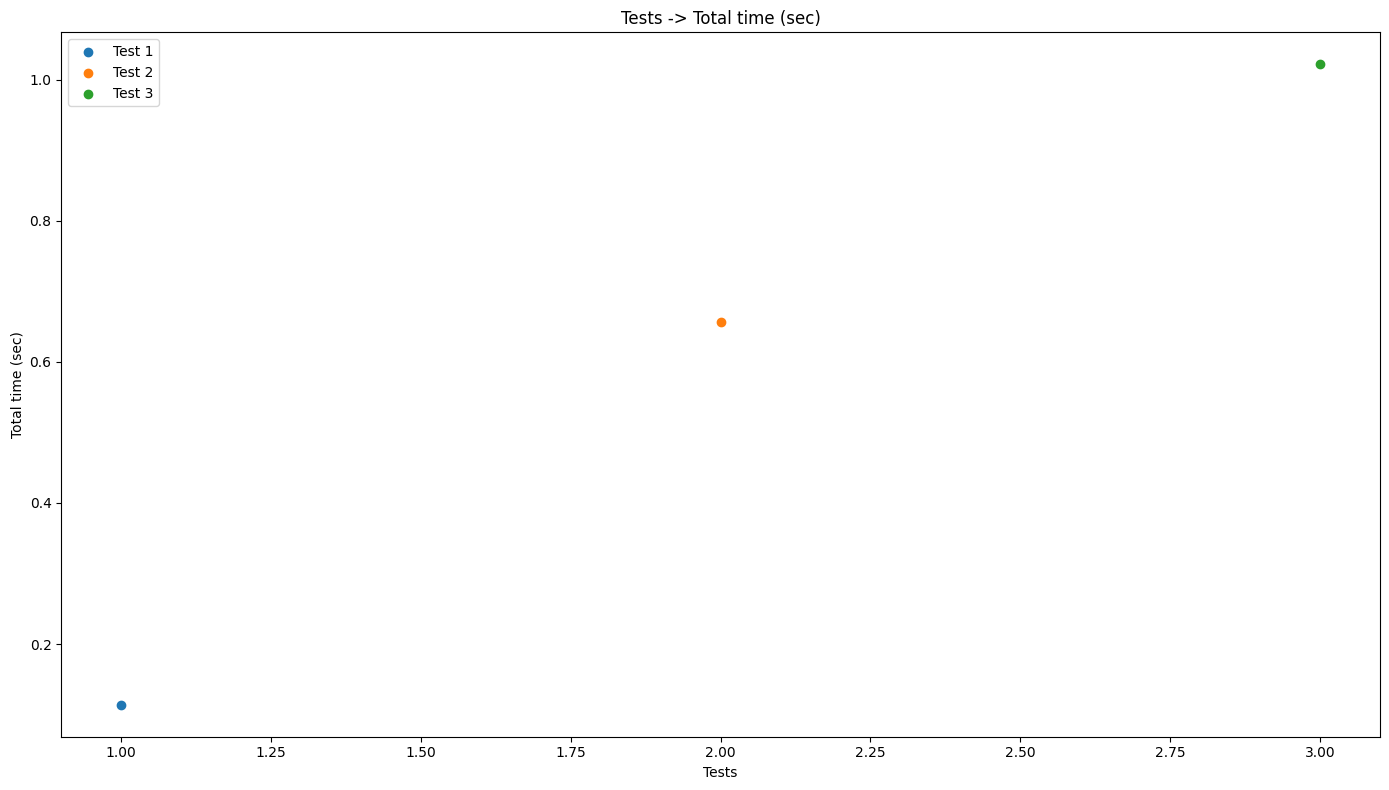

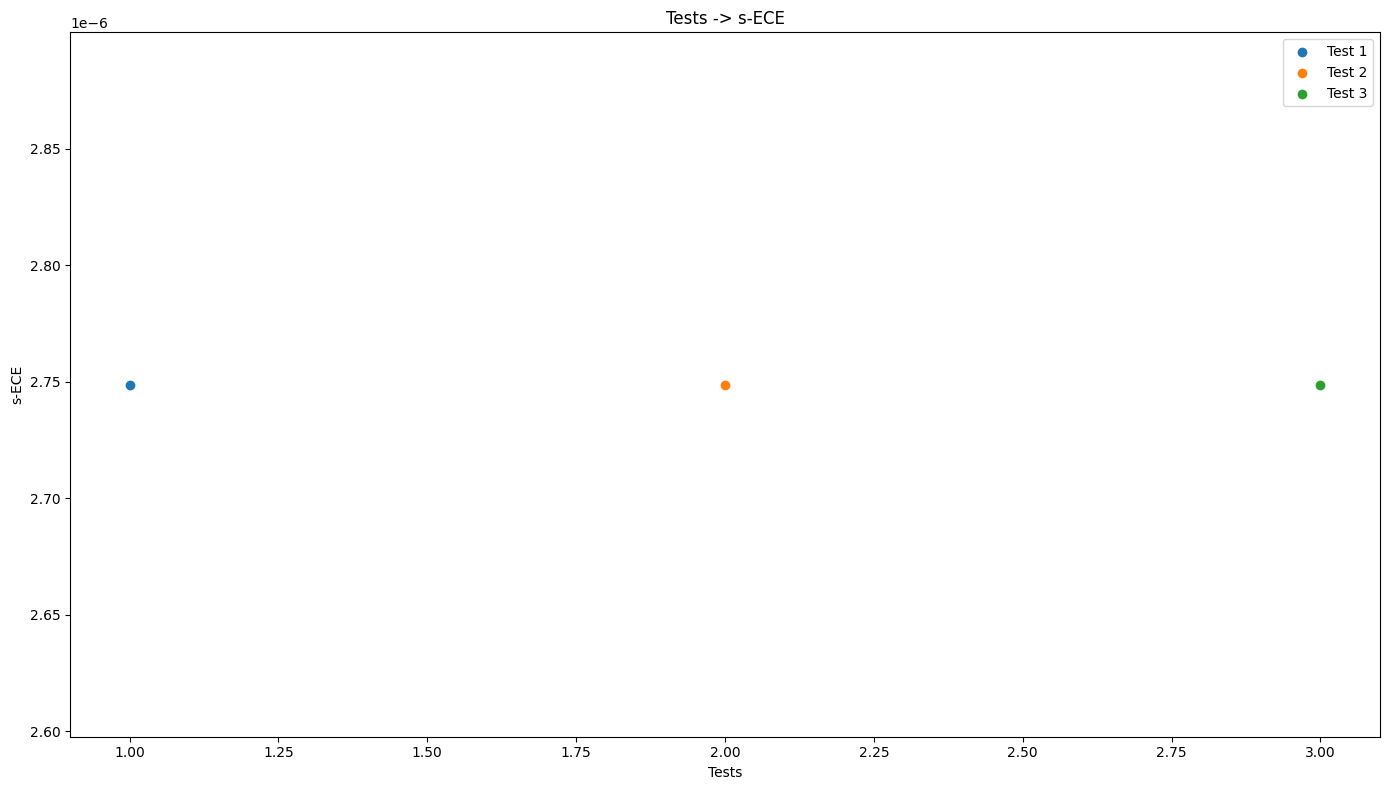

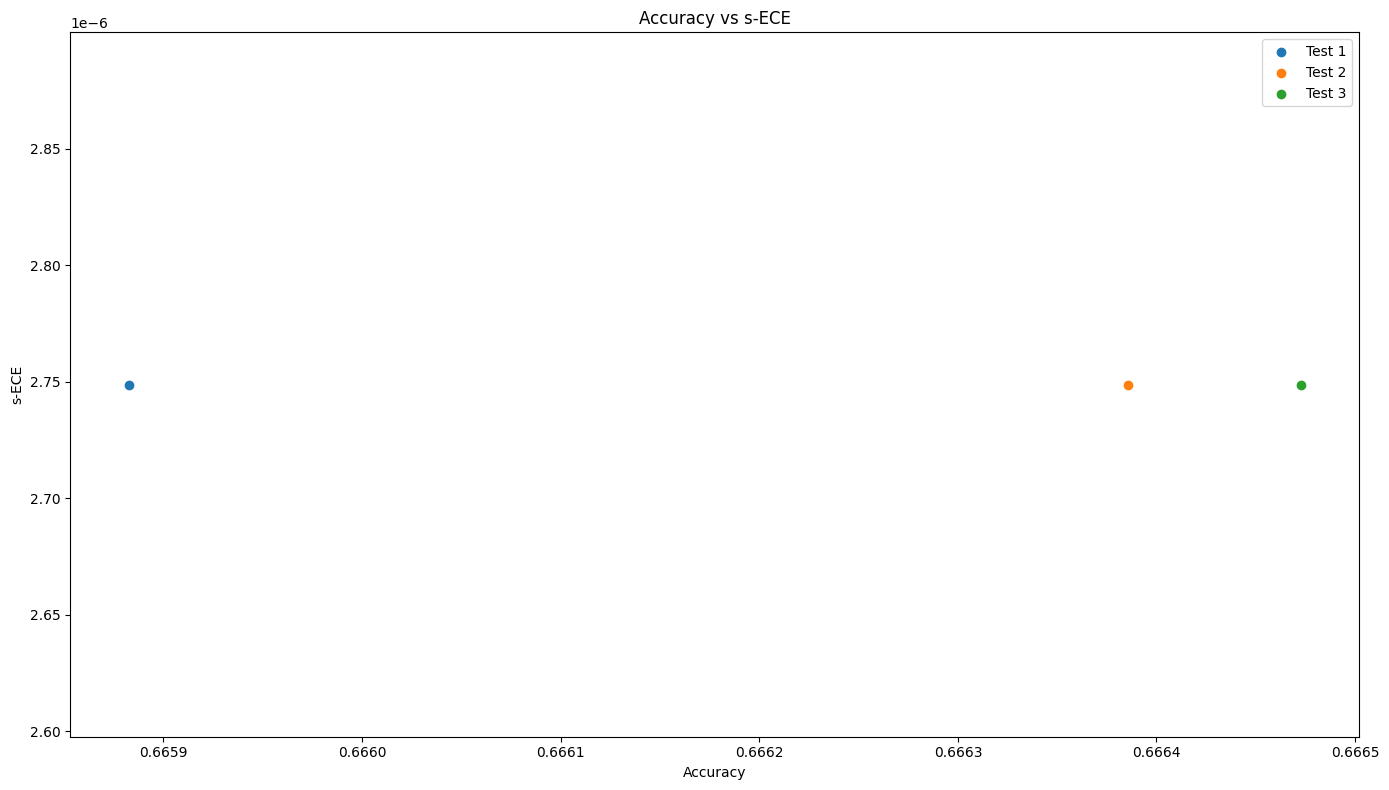

In [73]:
test_ids = range(1, len(models) + 1)
total_times = eval_times + training_times
graph_comparison(test_ids, total_times, 'Tests', 'Total time (sec)', '->')
graph_comparison(test_ids, ece_scores, 'Tests', 's-ECE', '->')
graph_comparison(accuracies, ece_scores, 'Accuracy', 's-ECE')

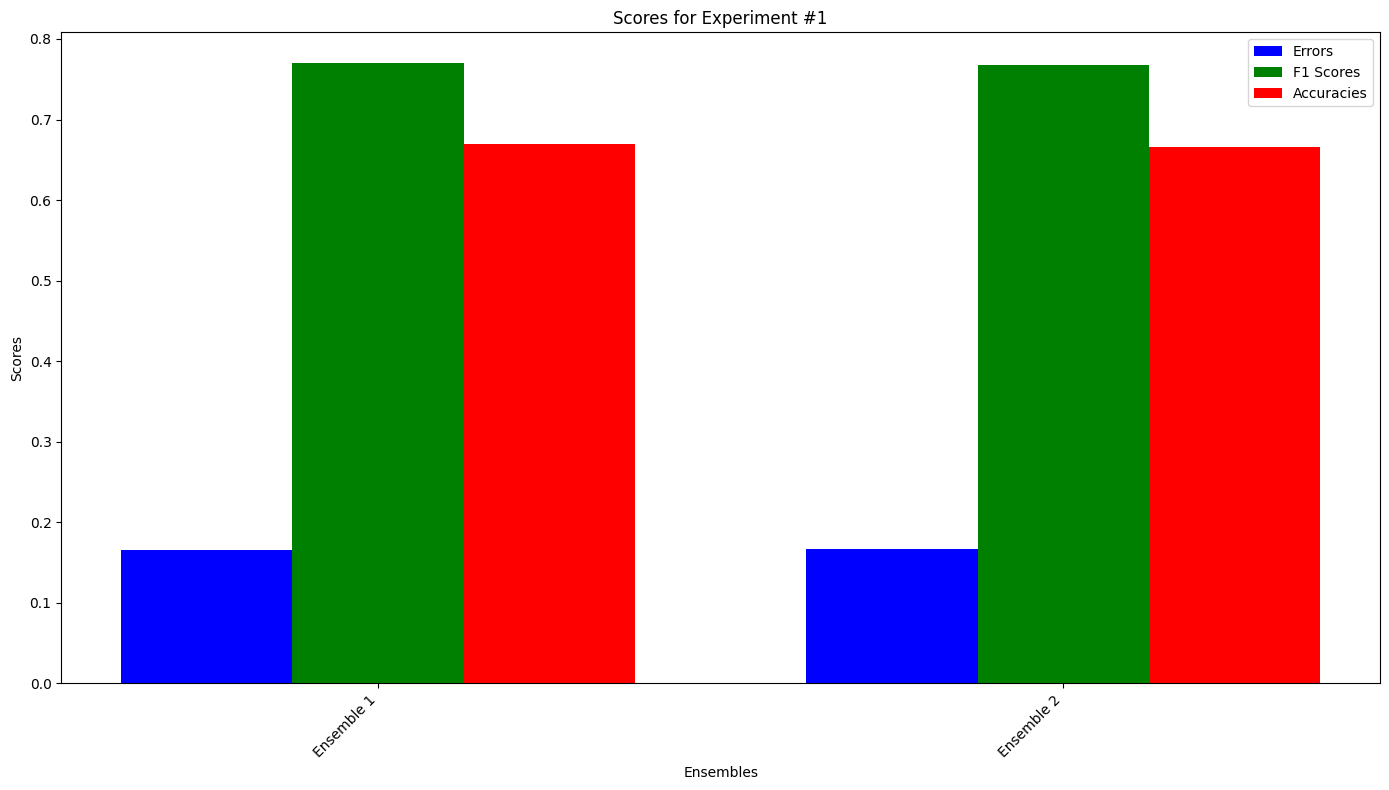

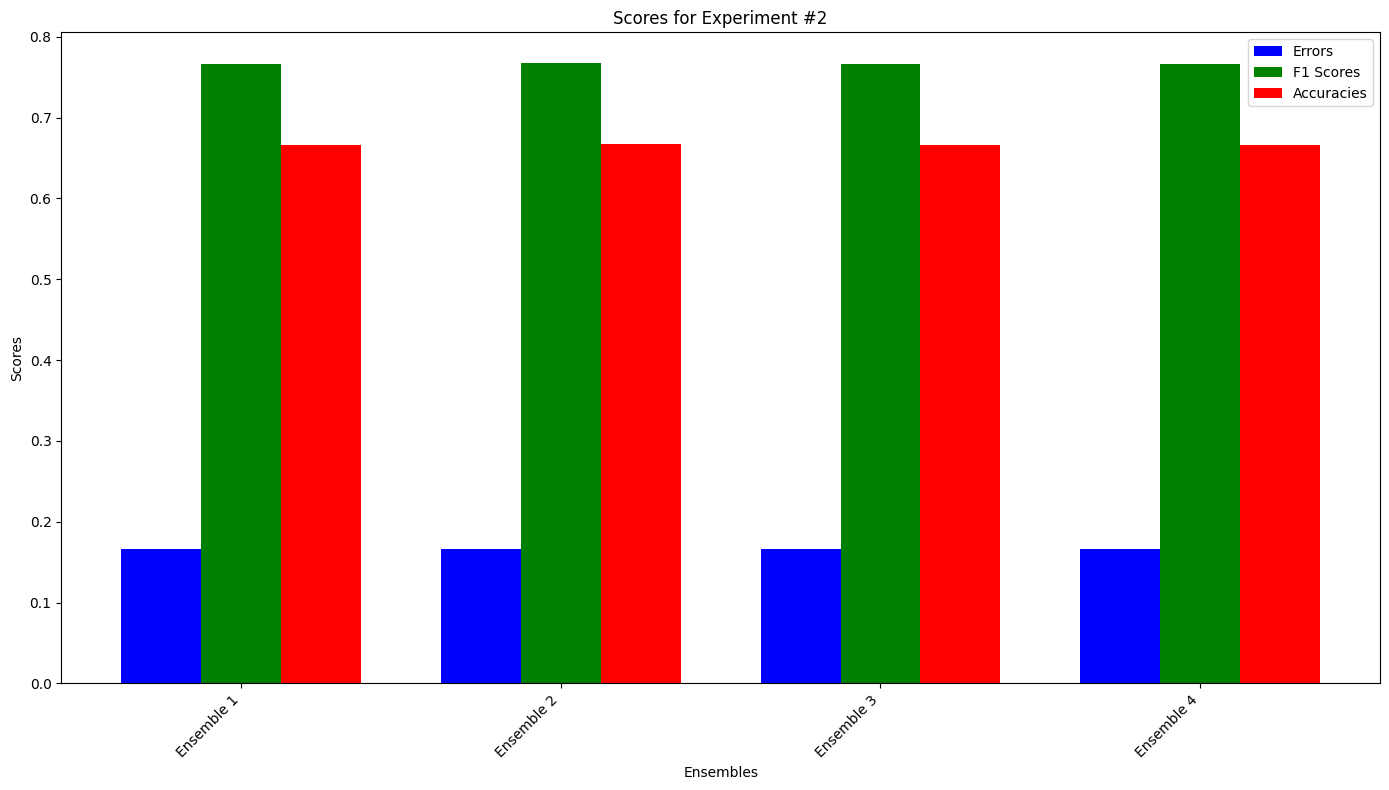

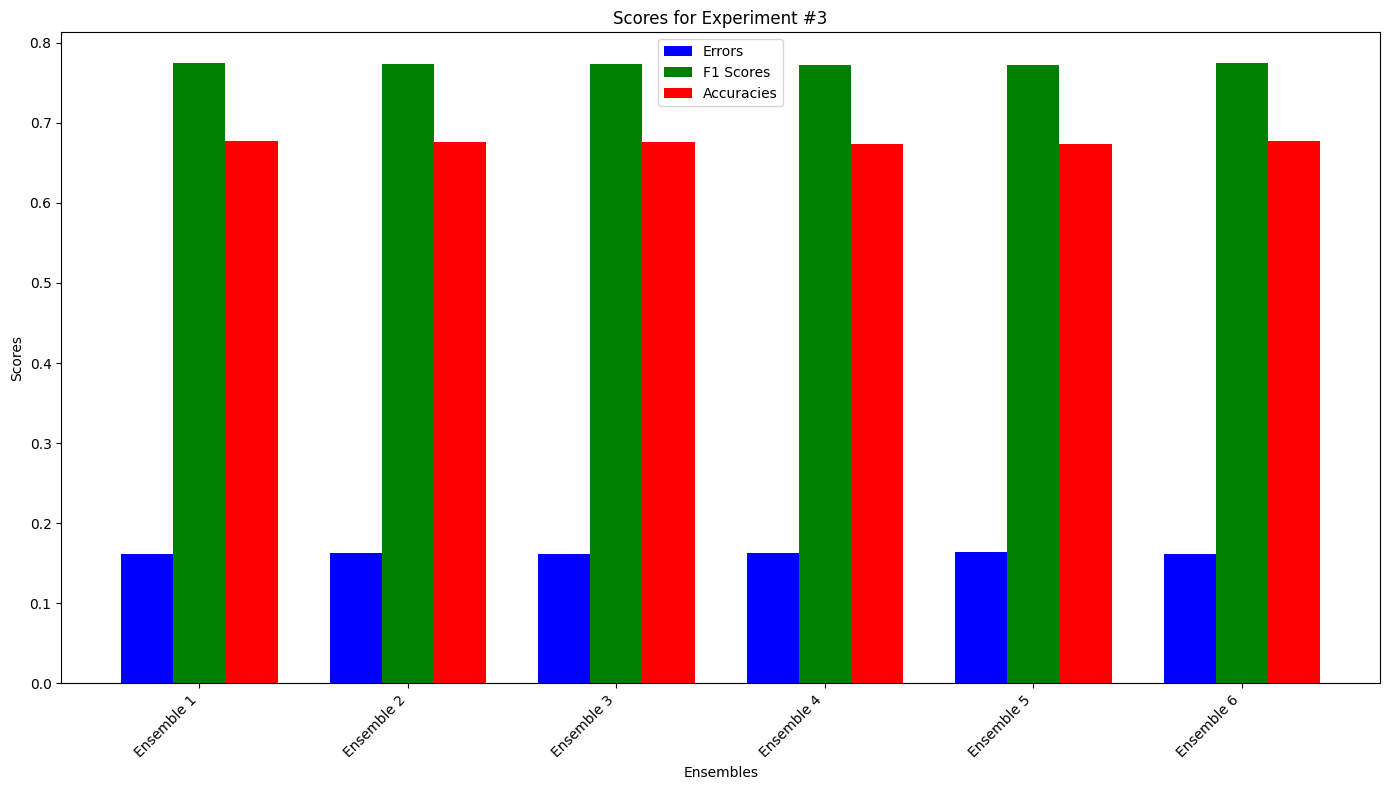

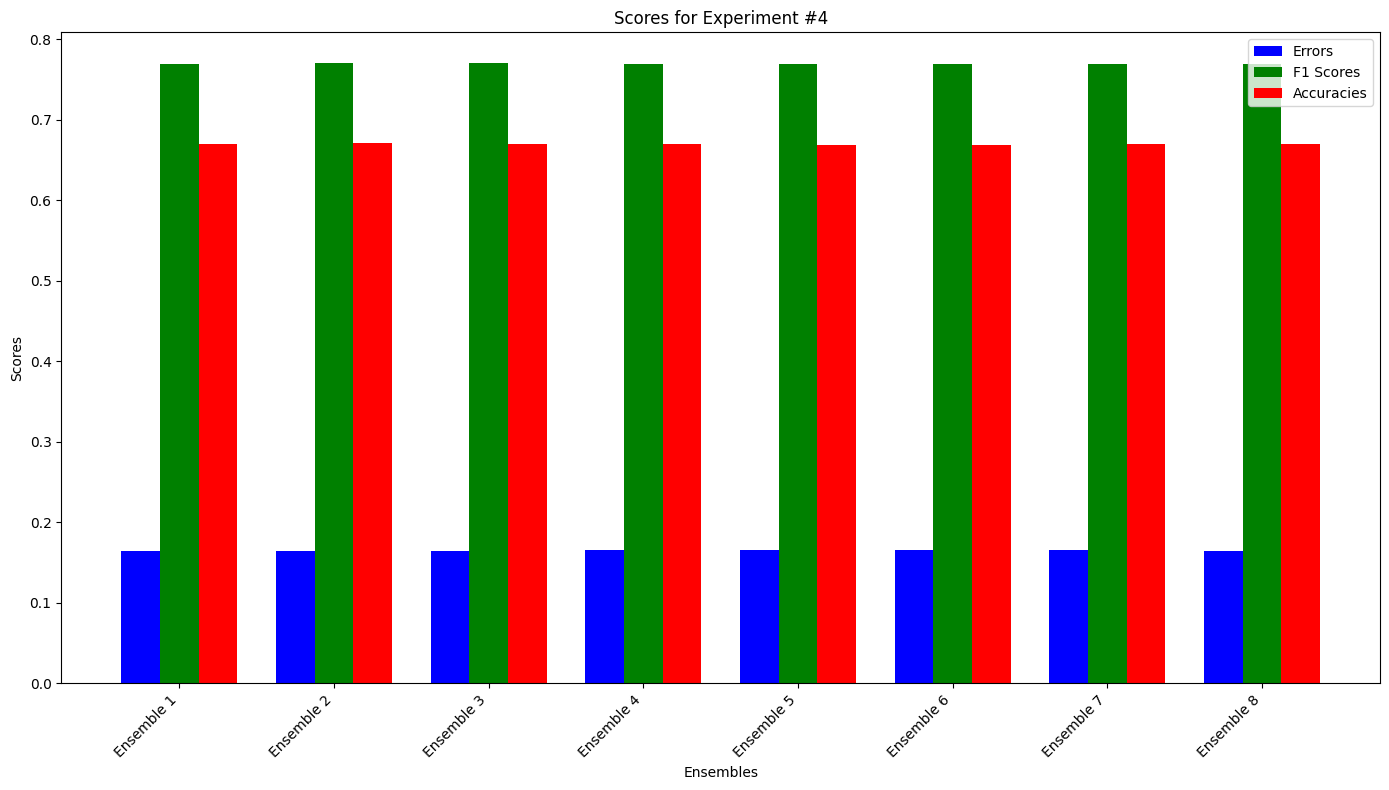

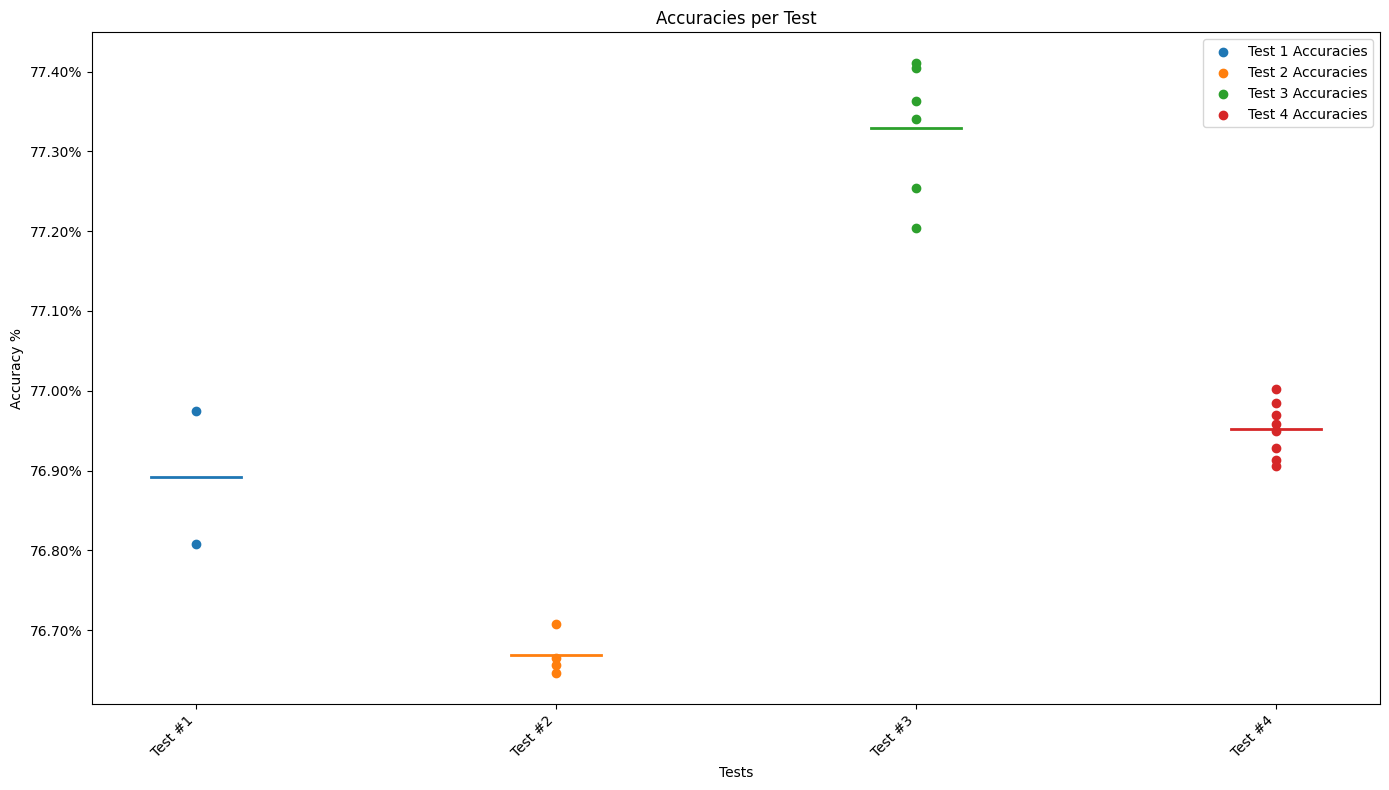

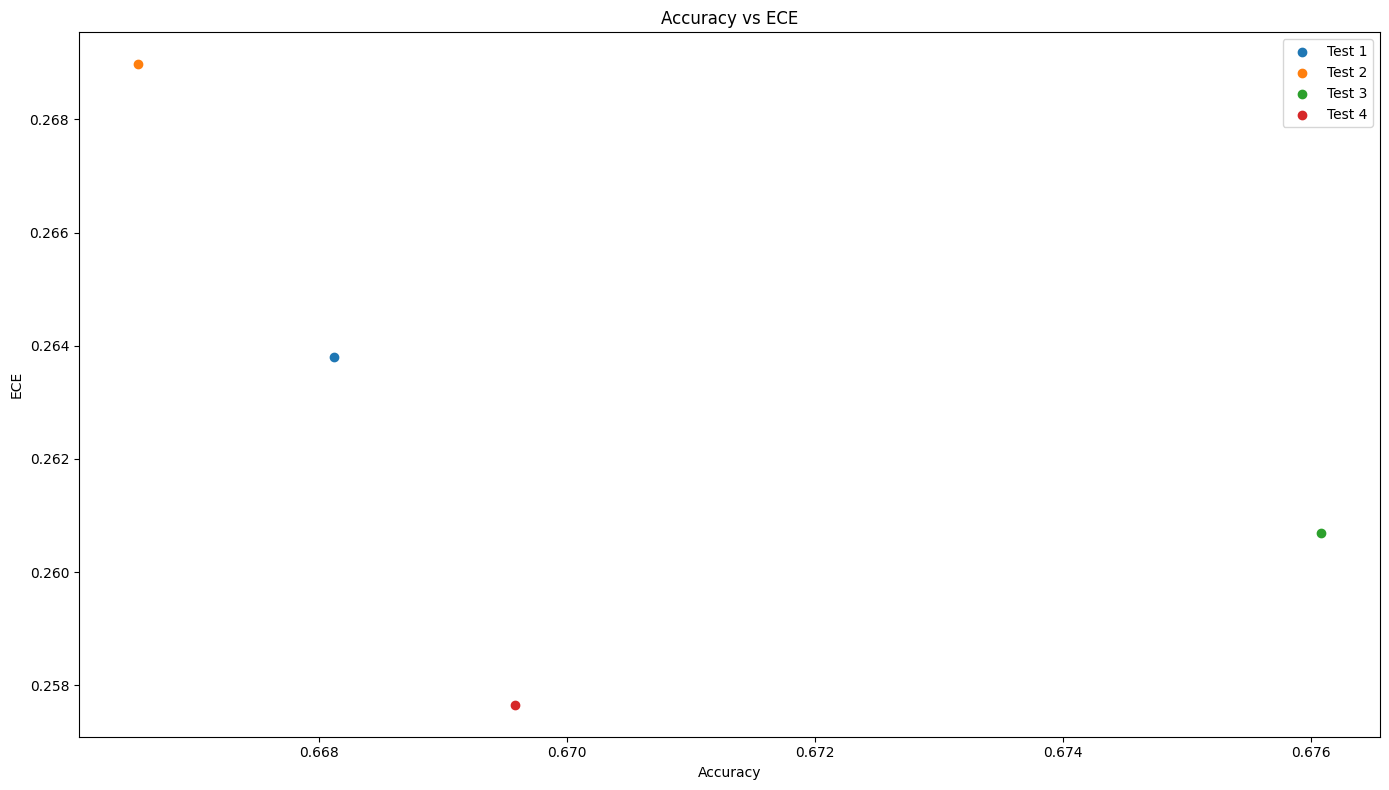

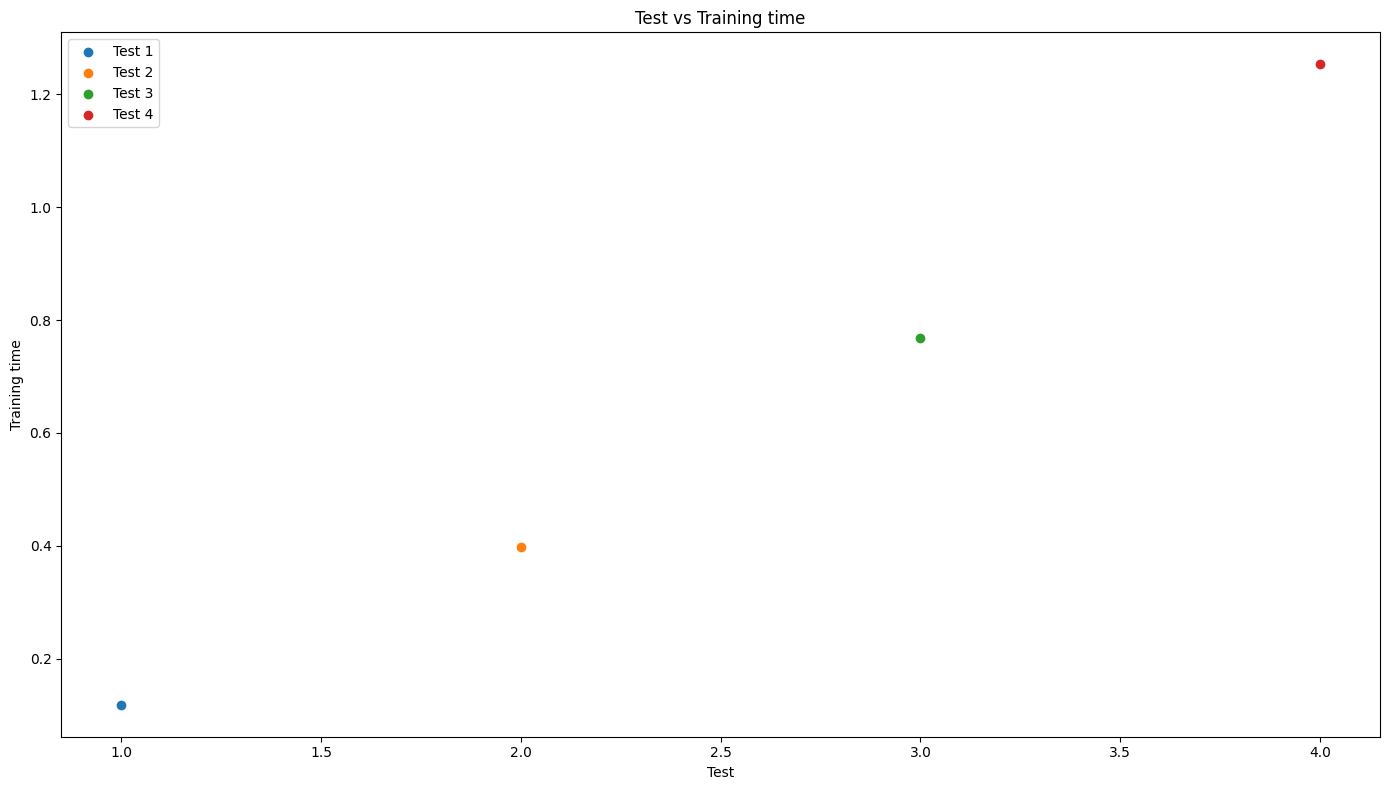

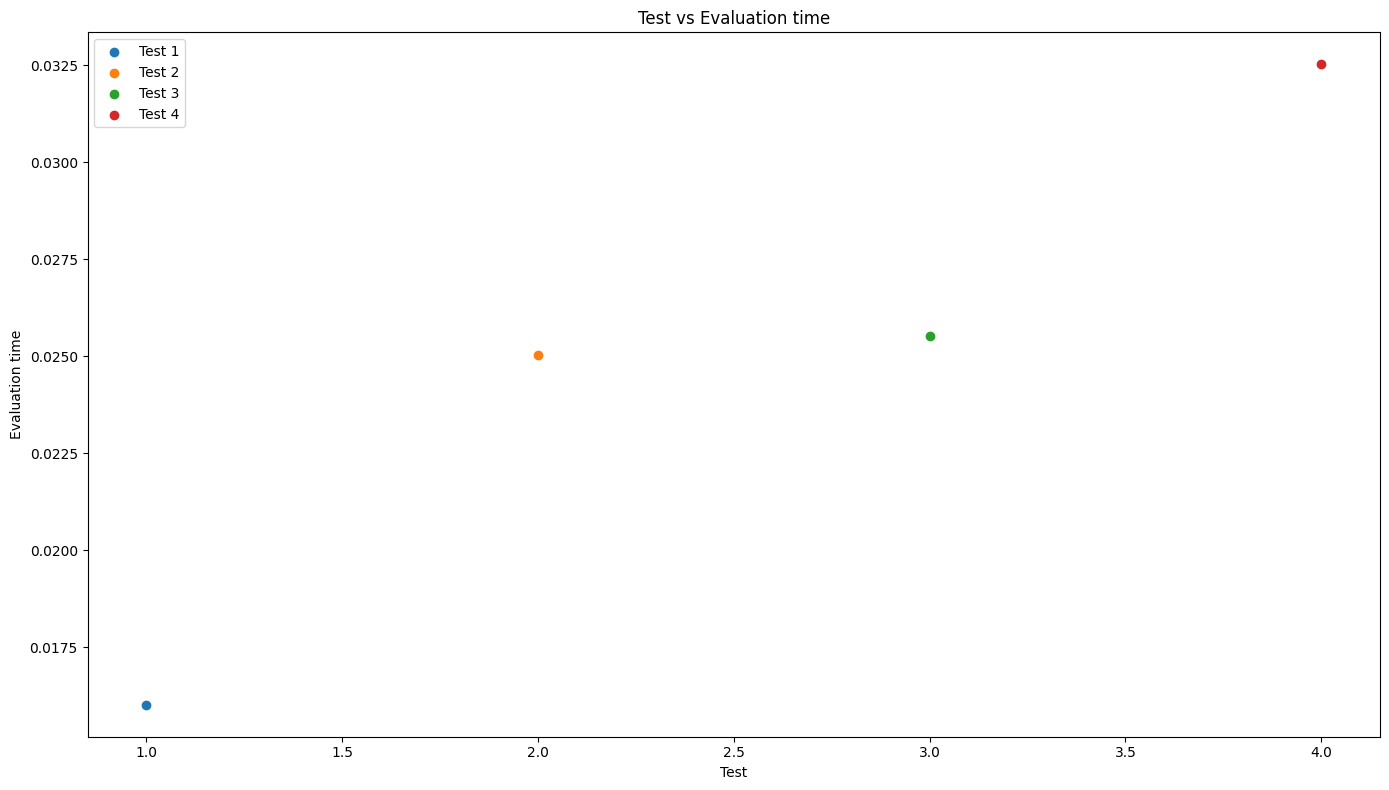

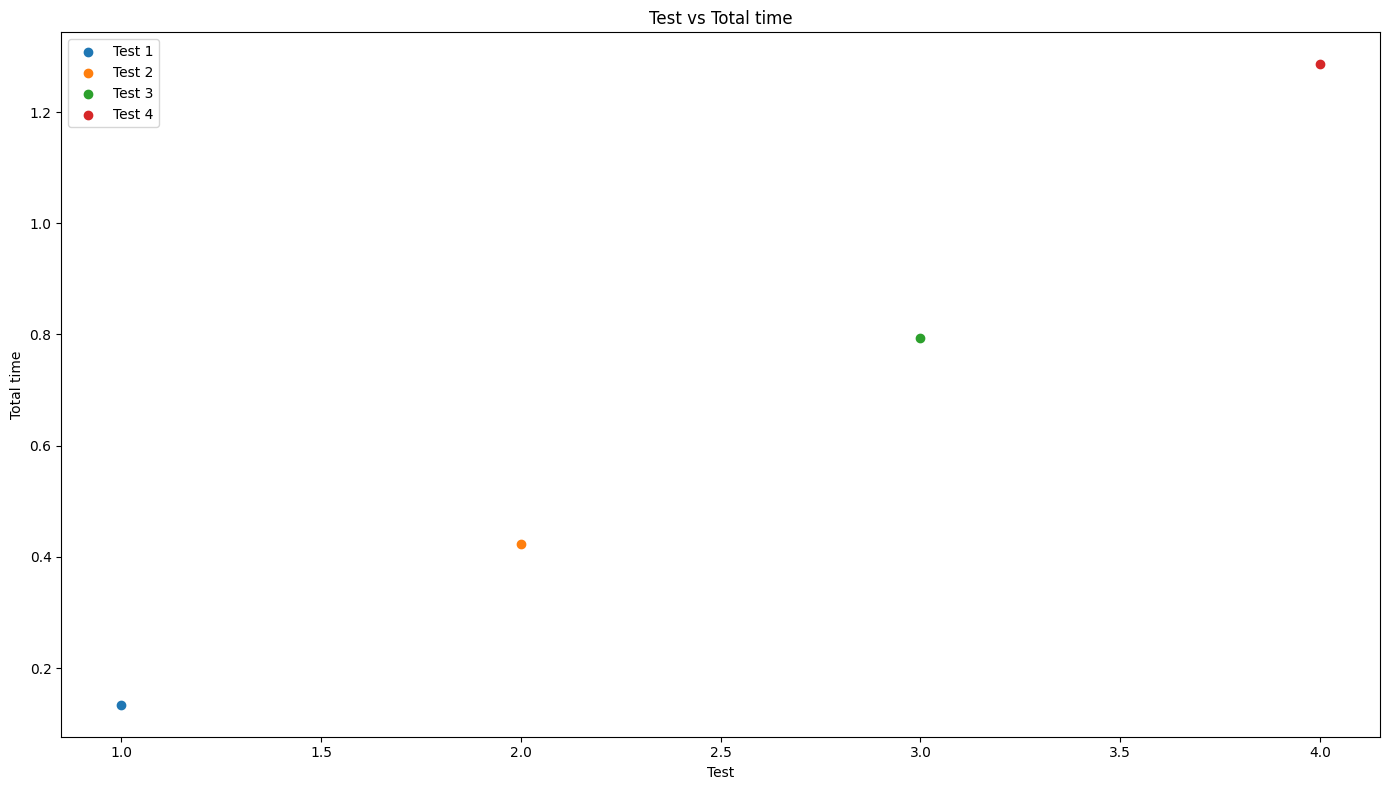

In [ ]:
models, results_per_experiment = execute_experiments(4, use_ensembles=True, n_ensembles=[2,4,6,8], verbose=False)

for i in range(len(models)):
    graph_ensemble_results(results_per_experiment[i][1], title=f'Scores for Experiment #{i+1}')

ensemble_accuracies = [results[1][2] for results in results_per_experiment]
graph_metric(ensemble_accuracies, 'Accuracy', 'Accuracies')

accuracies = [results[0][3] for results in results_per_experiment]
ece_scores = [results[0][5] for results in results_per_experiment]
graph_comparison(accuracies, ece_scores, x_title='Accuracy', y_title='ECE')

eval_times = [model.eval_time for model in models]
training_times = [model.train_time for model in models]
test_ids = range(1, len(models) + 1)
total_times = torch.tensor(training_times) + torch.tensor(eval_times)
graph_comparison(test_ids, training_times, 'Test', 'Training time')
graph_comparison(test_ids, eval_times, 'Test', 'Evaluation time')
graph_comparison(test_ids, total_times, 'Test', 'Total time')


#  Test model

In [ ]:
y_predictions = np.round(y_predictions).astype(int)
y_test = np.round(y_test).astype(int)
print(y_predictions)
print(y_test)

NameError: name 'y_predictions' is not defined

In [ ]:


accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 74.93%
Recall: 74.93%
Precision: 77.03%
F1-Score: 74.87%
time to train: 50.02 s
time to predict: 0.00 s
total: 50.03 s


# ECE calculation

In [ ]:
import torch
uncertainty_scores, _ = torch.max(torch.tensor(y_predictions), dim = 1)
print("uncertainty_scores \n ", uncertainty_scores)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)